In [3]:
import cmocean
import gsw
import xarray as xr
import datetime
import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate
from scipy.io import loadmat
import numpy as np
import gsw
import matplotlib.pyplot as plt
import PyCO2SYS as pyco2

In [6]:
float_id = 5904842
float_file = str(float_id) +'_Sprof.nc'

In [38]:
data = xr.open_dataset(float_file)
lon  = data["LONGITUDE"]
lat  = data["LATITUDE"]
press = data["PRES_ADJUSTED"].values
temp = data["TEMP_ADJUSTED"]
salt = data["PSAL_ADJUSTED"]
oxy = data["DOXY_ADJUSTED"]
pH = data["PH_IN_SITU_TOTAL_ADJUSTED"]
julian_day = data["JULD"].values
reference_day = np.datetime64('1950-01-01T00:00:00.000000000')
ref_soccom_day = np.datetime64('2017-01-01T00:00:00.000000000')
#full_day = julian_day + reference_day
day_since = julian_day - ref_soccom_day
day_since = day_since/np.timedelta64(1, 'D')
no_profiles = len(day_since)

In [15]:
SA = gsw.SA_from_SP(salt,press,lon,lat)
CT = gsw.CT_from_t(SA,temp,press)
sigma0 = gsw.sigma0(SA,CT)

/var/folders/h1/5vzfnzns1rq1l8m7jr7wyct80000gn/T/ipykernel_18796/1789080301.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_1.show()


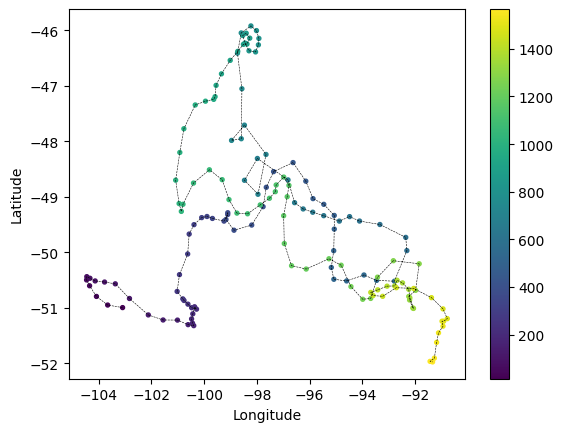

In [16]:
fig_1, ax_1 = plt.subplots()
ax_1.plot(lon,lat,'k',linestyle='dashed',linewidth=0.4)
cl1 = ax_1.scatter(lon,lat,s=32,c=day_since,marker=".")
fig_1.colorbar(cl1)
ax_1.set_xlabel("Longitude")
ax_1.set_ylabel("Latitude")
fig_1.show()

/var/folders/h1/5vzfnzns1rq1l8m7jr7wyct80000gn/T/ipykernel_18796/990976924.py:35: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_2.show()


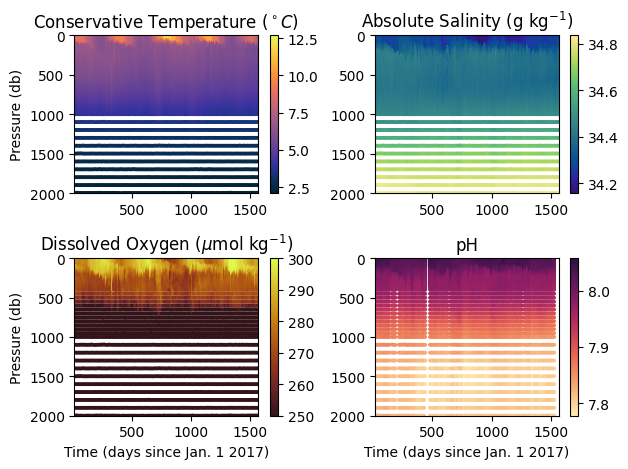

In [54]:
p_max = 2000

fig_2, ax_2 = plt.subplots(2,2)

X = np.tile(day_since,(np.size(press,1),1)).transpose()

cl2a = ax_2[0,0].scatter(X,press,c=CT,cmap=cmocean.cm.thermal,s=3)
ax_2[0,0].set_ylabel("Pressure (db)")
ax_2[0,0].set_title("Conservative Temperature ($^\circ C$)")
fig_2.colorbar(cl2a,ax=ax_2[0,0])

cl2b = ax_2[0,1].scatter(X,press,c=SA,cmap=cmocean.cm.haline,s=3)
ax_2[0,1].set_title("Absolute Salinity (g kg$^{-1}$)")
fig_2.colorbar(cl2b,ax=ax_2[0,1])

cl2c = ax_2[1,0].scatter(X,press,c=oxy,cmap=cmocean.cm.solar,s=3,vmin=250,vmax=300)
ax_2[1,0].set_ylabel("Pressure (db)")
ax_2[1,0].set_xlabel("Time (days since Jan. 1 2017)")
ax_2[1,0].set_title("Dissolved Oxygen ($\mu$mol kg$^{-1}$)")
fig_2.colorbar(cl2c,ax=ax_2[1,0])

cl2d = ax_2[1,1].scatter(X,press,c=pH,cmap=cmocean.cm.matter,s=3)
ax_2[1,1].set_xlabel("Time (days since Jan. 1 2017)")
ax_2[1,1].set_title("pH")
fig_2.colorbar(cl2d,ax=ax_2[1,1])

for ax in ax_2.flatten():
    ax.set_ylim(0,p_max)
    ax.set_xlim(np.min(day_since),np.max(day_since))
    ax.invert_yaxis()
    
for ax in fig_2.get_axes():
    ax.label_outer()
fig_2.tight_layout()
fig_2.show()


In [104]:
#ADD CODE HERE TO CALCULATE THE MLD
MLD = np.zeros(len(day_since))
for i in range(int(len(day_since))):
    kk = np.where(press[i,:]>10)[0][0]
    ll = np.where(sigma0[i,:]-sigma0[i,kk]-0.03>0)
    if len(ll[0])!=0:
        MLD[i] = press[i,ll[0][0]]
    else:
        MLD[i] = np.nan

/var/folders/h1/5vzfnzns1rq1l8m7jr7wyct80000gn/T/ipykernel_18796/938364709.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_3.show()


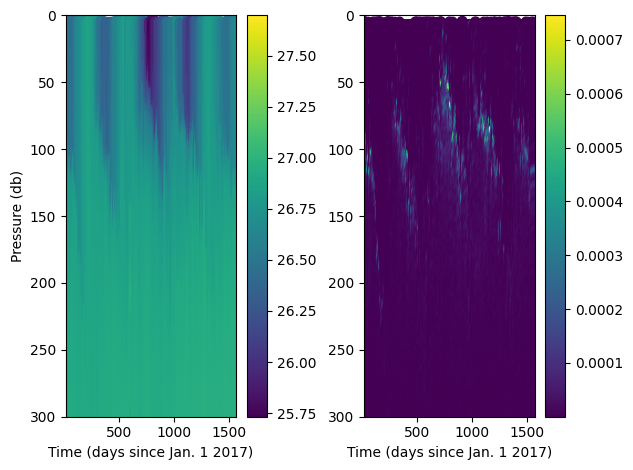

In [120]:
g=9.8
rho0=1026
N2 = np.zeros((len(day_since),557))
for i in range(len(day_since)):
    sigma0_sort = np.sort(sigma0[i,:])
    N2[i,:] = (g/rho0)*(sigma0_sort[2:-1]-sigma0_sort[0:-3])/(press[i,2:-1]-press[i,0:-3])

fig_3, ax_3 = plt.subplots(1,2)
#UNCOMMENT THIS TO PLOT MLD
#ax_3[0].plot(X[:,1],MLD,linewidth=2,c='k')
#ax_3[1].plot(X[:,1],MLD,linewidth=2,c='k')

cl3a = ax_3[0].scatter(X,press,c=sigma0)
fig_3.colorbar(cl3a,ax=ax_3[0])
ax_3[0].set_ylabel("Pressure (db)")
ax_3[0].set_xlabel("Time (days since Jan. 1 2017)")

cl3b = ax_3[1].scatter(X[:,1:-2],press[:,1:-2],c=N2)
fig_3.colorbar(cl3b,ax=ax_3[1])
ax_3[1].set_xlabel("Time (days since Jan. 1 2017)")

for ax in ax_3.flatten():
    ax.set_ylim(0,300)
    ax.set_xlim(np.min(day_since),np.max(day_since))
    ax.invert_yaxis()
fig_3.tight_layout()
fig_3.show()

In [56]:
#CALCULATE THE MEAN AND VARIANCE OF THE MLD HERE


In [124]:
#ADD CODE TO CALCULATE THE MLD AVERAGE TEMPERATURE, SALINITY, OXYGEN AND pH
temp_mix = np.zeros(len(day_since))
salt_mix = np.zeros(len(day_since))
oxy_mix = np.zeros(len(day_since))
pH_mix = np.zeros(len(day_since))
for i in range(int(len(day_since))):
    kk = np.where(press[:,i]<MLD[i])[0]
    temp_mix[i] = np.mean(temp[i,kk])### Complete this line
    salt_mix[i] = np.mean(salt[i,kk])### Complete this line
    oxy_mix[i]  = np.mean(oxy[i,kk])### Complete this line
    pH_mix[i]   = np.mean(pH[i,kk])### Complete this line

AttributeError: 'list' object has no attribute 'set_ylabel'

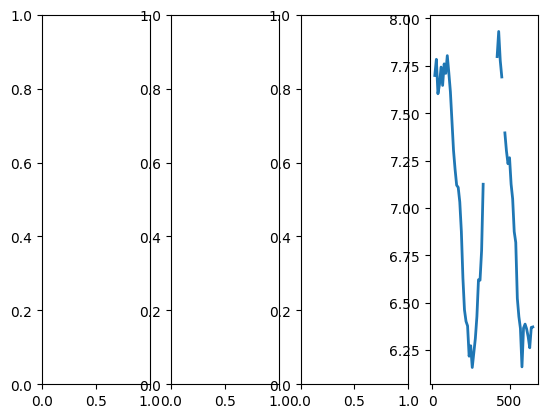

In [126]:
fig_4, ax_4 = plt.subplots(1,4)
ax_4[0] = plt.plot(X[:,1],temp_mix,linewidth=2)
ax_4[0].set_ylabel("Surface Temperature")

ax_4[1] = plt.plot(X[:,1],salt_mix,linewidth=2)
ax_4[1].set_ylabel("Surface Salinity")

ax_4[2] = plt.plot(X[:,1],oxy_mix,linewidth=2)
ax_4[2].set_ylabel("Surface O2")

ax_4[3] = plt.plot(X[:,1],pH_mix,linewidth=2)
ax_4[3].set_ylabel("Surface pH")

for ax in ax_4.flatten():
    ax.set_ylim(0,300)
    ax.set_xlim(np.min(day_since),np.max(day_since))
    ax.invert_yaxis()

for ax in fig_4.get_axes():
    ax.label_outer()
fig_4.show()

In [127]:
pyco2_kws = dict()
pyco2_kws["par1_type"] = 1; # The first parameter supplied is of type "1", which is "alkalinity"
pyco2_kws["par1"] = 2300; # value of the first parameter
pyco2_kws["par2_type"] = 3; # The second parameter supplied is of type "2", which is "pH"
pyco2_kws["par2"] = pH_mix; # value of the second parameter, which is a long vector of different pH's!

pyco2_kws["salinity"] = salt_mix;  # Salinity of the sample
pyco2_kws["temperature"] = temp_mix;  # Temperature at input conditions
pyco2_kws["pressure"] = 0;  # Pressure    at input conditions
pyco2_kws["temperature_out"]  = 0;  # Temperature at output conditions - doesn't matter in this example
pyco2_kws["pressure_out"]  =  0;  # Pressure    at output conditions - doesn't matter in this example
pyco2_kws["total_silicate"] =   20;  # Concentration of silicate  in the sample (in umol/kg)
pyco2_kws["total_phosphate"] =    2;  # Concentration of phosphate in the sample (in umol/kg)
pyco2_kws["opt_pH_scale"]  =    1;  # pH scale at which the input pH is reported ("1" means "Total Scale")  - doesn't matter in this example


pyco2_kws["opt_k_carbonic"] = 4;  #Choice of H2CO3 and HCO3- dissociation constants K1 and K2 ("4" means "Mehrbach refit")

pyco2_kws["opt_k_bisulfate"] = 1;  #Choice of HSO4- dissociation constants KSO4 ("1" means "Dickson")

A = pyco2.sys(**pyco2_kws)

In [65]:
#ADD CODE TO LOOK UP VARIOUS TERMS STORED IN A

#pCO2_oc = ### Complete this line  ###  ### Surface ocean pCO2
#DIC_oc = ### Complete this line ###    ### Surface DIC
#bicarb = ### Complete this line ###    ### Surface bicarbonate ion concentration
#carb = ### Complete this line ###      ### Surface carbonate ion concentration
#K0 = ### Complete this line ###        ### Surface solubility

NameError: name 'temp_mix' is not defined

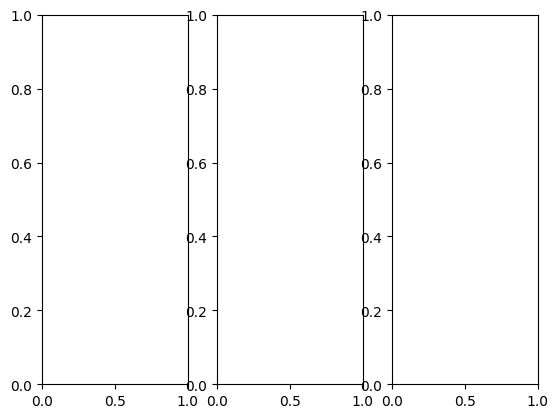

In [66]:
fig_5, ax_5 = plt.subplots(1,3)
ax_5[0] = plt.plot(X[:,1],temp_mix,linewidth=2)
ax_5[0].set_ylabel("Surface Temperature")

ax_5[1] = plt.plot(X[:,1],K0,linewidth=2)
ax_5[1].set_ylabel("Surface Salinity")

ax_5[2] = plt.plot(X,pCO2_oc,linewidth=2)
ax_5[2].set_ylabel("Surface O2")


for ax in ax_5.flatten():
    ax.set_ylim(0,300)
    ax.set_xlim(np.min(day_since),np.max(day_since))
    ax.invert_yaxis()

for ax in fig_5.get_axes():
    ax.label_outer()
fig_5.show()